# Introduction to Reinforcement Learning
This lecture notes is taken to study for the fundamental concepts of reinforcement learning. Notes for each course and textboot will be taken in a different jupyter notebook. This notebook containes the notes of the [Udemy Course - _Reinforcement Learning in Python_](https://www.udemy.com/course/artificial-intelligence-reinforcement-learning-in-python/) and [Coursera Course - _Fundamentals in Reinforcement Learning_](https://www.coursera.org/learn/fundamentals-of-reinforcement-learning?specialization=reinforcement-learning)

## Multi-Armed Bandit Problem
### Explore - Exploit Dilemma
The exploration-exploitation dilemma is a very general problem that can be encountered in most of the data driven decision making process when there exists some kind of feedback loop between data gathering and decisions making. In other words, as soon as a model is no longer « spectator » but becomes « actor » of the way data are collected, the exploration-exploitation dilemma arise.

Let’s consider two examples to illustrate our point: first, the offline training of a face detection model and, second, the online training of a model that predicts the click through rates of some ads.

In the case of the face detector model, data are collected before the training. Once it has been trained, the model is used in some way or another but no new data are collected and, so, there is no feedback loop to be careful about. Exploration-exploitation trade-off is not a concern: the model has no role in the data gathering process and its outputs can be used as such with no further exploration required.

![](images/image1.png)

Conversely, in the click prediction case, the model is continuously updated and training happens at the same time as data are collected. Data observed so far are used to train a model, the model is used to select the best ads to be displayed, new gathered data (click or no click) can be used to update the model and so on. The model is then « actor » in the data gathering process and the exploration-exploitation trade-off needs to be considered carefully.

![](images/image2.png)

Indeed, with no exploration, a model that wrongly predicts poor performances for an ad (either because we have no data, inaccurate data or outdated data for this ad) won’t have any chances to correct itself with new observations because the ad won’t be displayed anymore. Considering some exploration will make it possible to give a try to this ad and collect more data that prove the model wrong and update it.

In general, this kind of __online learning__ process is often required either when there is not enough past data to train a reliable model (cold start problem) or when data are evolving through the time (non-stationary problem). In both cases, the knowledge derived from data observed so far doesn’t allow us to identify the best decision to be taken with absolute certainty (the best ad to display in our example). We then have to make a fundamental choice between the best decision according to our current knowledge (exploitation) and any other decision that could be shown to be the best with more information (exploration).

To summarize, explore - exploit dilemma for reinforcement learning is that the corresponding agent of the system have to choose exploring the situations or exploitation for best result since it cannot achieve both of them simultaneously.

### Epsilon - Greedy Algorithm
__Problem Definition:__ Assume you (or an agent) in a casino and there are several slot machines (bandits). These slot machines are giving a reward 1 with a certain probability, and 0 othwerwise. The reward probabilities for each slot machine is unknown and the goal is maximizing the reward in each play. In this concept, we will call the slot machines as bandits.

How do we solve this problem? Because of explore - exploit dilemma _- we cannot achieve exploration and explotation at the same time -_, we have to create a balance between them. Maybe, we can start with a random choice of bandits, and after that, we can choose the one with the best win rate.

Pseudocode for greedy algorithm:

    while True:
        j = argmax(predicted bandit means)
        x = play bandit j and get reward
        bandits[j].update_mean(x)

- Choosing the best MLE win rate doesn't work, which is called greedy method.
- For us, greedy means picking the bandit with highest MLE win rate, with no regard to confidence in prediction or amount of data collected.

__Epsilon-Greedy Algorithm:__ Epsilon greedy is a method to solve the no exploration problem in the pure greedy algorithm. In this algorithm, the agent choose exploration with a small probability (epsilon), in other cases, it chooses the bandit like a greedy algorithm. Typical values for epsilon is 0.05 or 0.1.

Pseudocode for epsilon-greedy Algorithm:

    while True:
        p = random number in [0, 1]
        if p < epsilon:
            j = choose a random bandit
        else:
            j = argmax(predicted bandit means)
        x = play bandit j and get reward
        bandits[j].update_mean(x)
        
- The purpose of exploration (with nonzero epsilon) is so the agent can collect data about each bandit.
- The problem is for a constant epsilon the exploration will never stop even if we have enough data to choose the highest one and this situation will cause a loss in the optimal reward.
- We can use decaying epsilons _-with respect to time-_ which can be helpful for stationary problems but in non-stationary problems, constant epsilon could be more helpful.

In [70]:
# library imports
import math
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import List, Callable
%matplotlib inline

In [64]:
# bandit class implementation
class Bandit:
    def __init__(self, probability: float):
        self.probability = probability
        self.num_samples = 0
    
    def pull(self):
        self.num_samples += 1
        if random.random() < self.probability:
            return 1
        else:
            return 0

In [65]:
# agent class implementation
class Agent:
    def __init__(self, bandit_probabilities: List[float]):
        self.choose = None
        self.choose_params = None
        self.bandits = [Bandit(prob) for prob in bandit_probabilities]
        self.bandit_means = np.zeros(len(self.bandits))

    def set_agent_algorithm(self, agent_algorithm: Callable[[], int], **params):
        self.choose = agent_algorithm.__get__(self)
        self.choose_parameters = params

    def update_bandit(self, reward: int, bandit_num: int):
        self.bandit_means[bandit_num] += 1/self.bandits[bandit_num].num_samples * (reward - self.bandit_means[bandit_num])

    def play_one_turn(self):
        bandit_num = self.choose()
        reward = self.bandits[bandit_num].pull()
        self.update_bandit(reward, bandit_num)
        return reward

In [66]:
# experiment class implementation
class Experiment:
    def __init__(self, agent: Agent):
        self.agent = agent
        self.iterations = []
        self.mean_rewards = [0]
        self.means = []
        self.legend = []

    def calculate_mean_reward(self, reward):
        mean_reward = float(self.mean_rewards[-1])
        mean_reward += (reward - mean_reward) / len(self.mean_rewards)
        return mean_reward
    
    def run(self, iter_num: int):
        for i in tqdm(range(1, iter_num + 1)):
            self.iterations.append(i)
            self.mean_rewards.append(self.calculate_mean_reward(self.agent.play_one_turn()))
            self.means.append(self.agent.bandit_means.copy())
            
    def plot_mean_rewards(self, color='b'):
        plt.rcParams["figure.figsize"] = (20,10)
        plt.plot(self.iterations, self.mean_rewards[1:], c=color)
        plt.xlabel("Iteration Number")
        plt.ylabel("Mean Reward")
        plt.ylim([0, 1])
        self.legend.append("reward")

    def plot_bandit_estimates(self, colors=List[str]):
        means = np.stack(self.means, axis=1)
        for i in range(means.shape[0]):
            plt.plot(self.iterations, means[i], c=colors[i])
            self.legend.append("bandit_{} prob est".format(i))
        plt.xlabel("Iteration Number")
        plt.ylabel("Estimations for bandits")
        plt.ylim([0, 1])
        plt.legend(self.legend)

Now, since we finished implementation of the bandit, agent and experiment classes, we can start experiments. Let's start with pure greedy approach and reward return.

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 81169.17it/s]


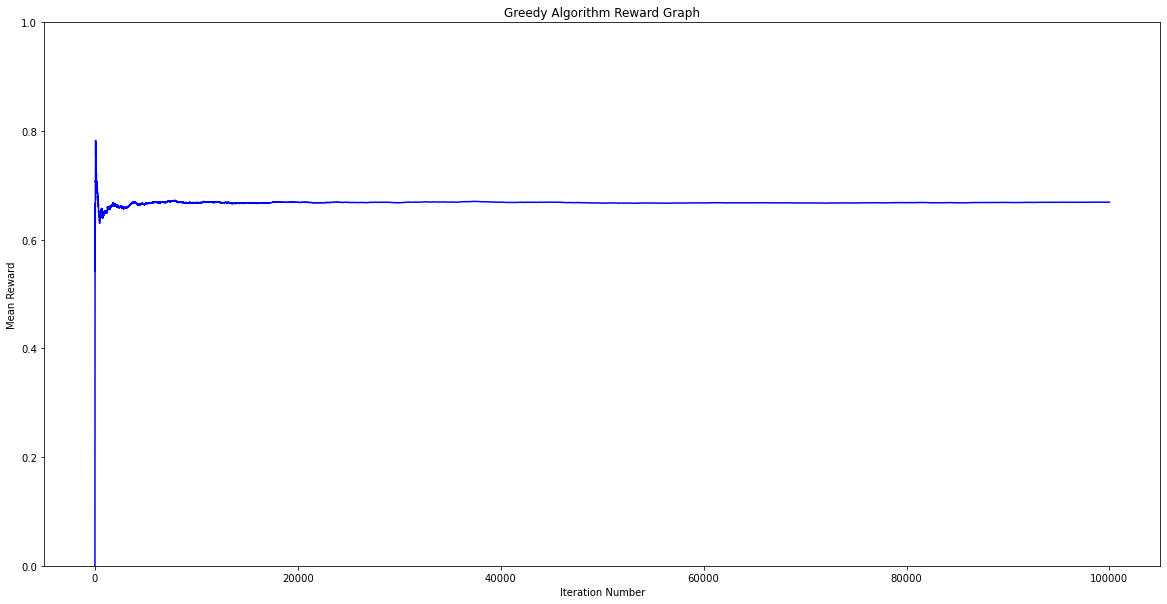

In [73]:
def use_greedy(self) -> int:
    bandit_num = np.random.choice(np.argwhere(self.bandit_means == np.max(self.bandit_means)).squeeze(axis=1))
    return bandit_num


bandit_probs = [0.2, 0.34, 0.56, 0.67, 0.81]
colors = ['r', 'g', 'c', 'm', 'k']

agent = Agent(bandit_probs)
agent.set_agent_algorithm(use_greedy)
experiment = Experiment(agent)
experiment.run(100000)
experiment.plot_mean_rewards()
_ = plt.title("Greedy Algorithm Reward Graph")

When we run the cell above several times, final reward will change significantly since the reward depends on the initial random start. It's a little problem. In order to solve this issue, let's implement epsilon-greedy algorithm.

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 87311.68it/s]


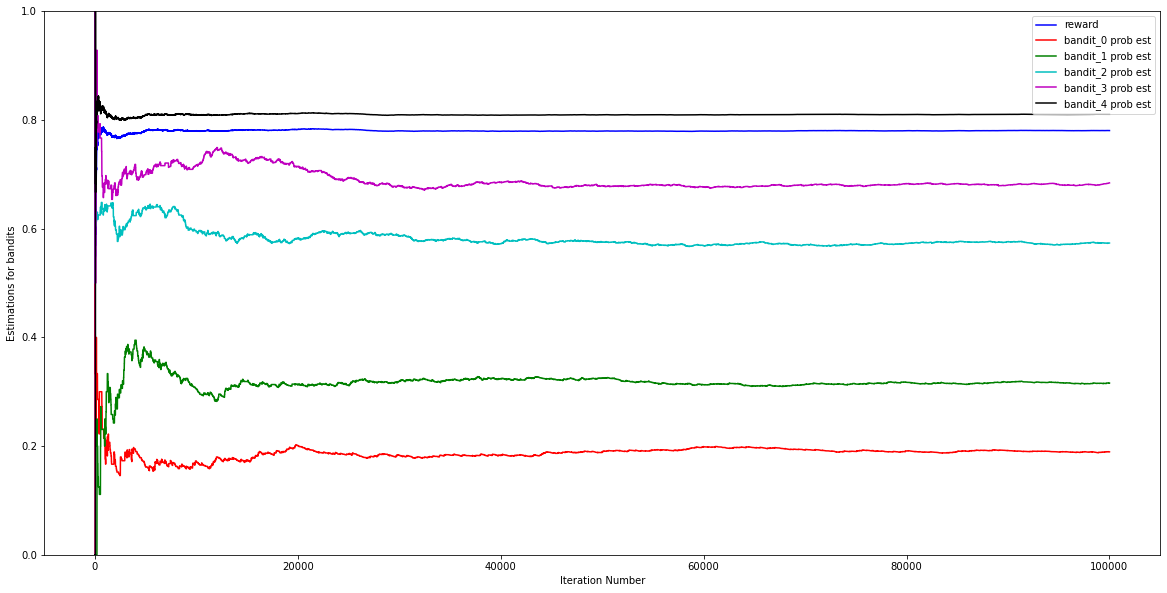

In [62]:
def use_epsilon_greedy(self) -> int:
    if random.random() < self.choose_parameters["epsilon"]:
        bandit_num = random.randint(0, len(self.bandits) - 1)
    else:
        bandit_num = np.random.choice(np.argwhere(self.bandit_means == np.max(self.bandit_means)).squeeze(axis=1))
    return bandit_num


bandit_probs = [0.2, 0.34, 0.56, 0.67, 0.81]
colors = ['r', 'g', 'c', 'm', 'k']

agent = Agent(bandit_probs)
agent.set_agent_algorithm(use_epsilon_greedy, epsilon=0.1)
experiment = Experiment(agent)
experiment.run(100000)
experiment.plot_mean_rewards()
experiment.plot_bandit_estimates(colors)

If we run the cell above several times, although the first 20,000 iteration steps are different in each time, the final estimation and reward results will become almost same. Now, analyze the reward and epsilon value relation for running several experiments with different epsilon values:

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 84919.28it/s]


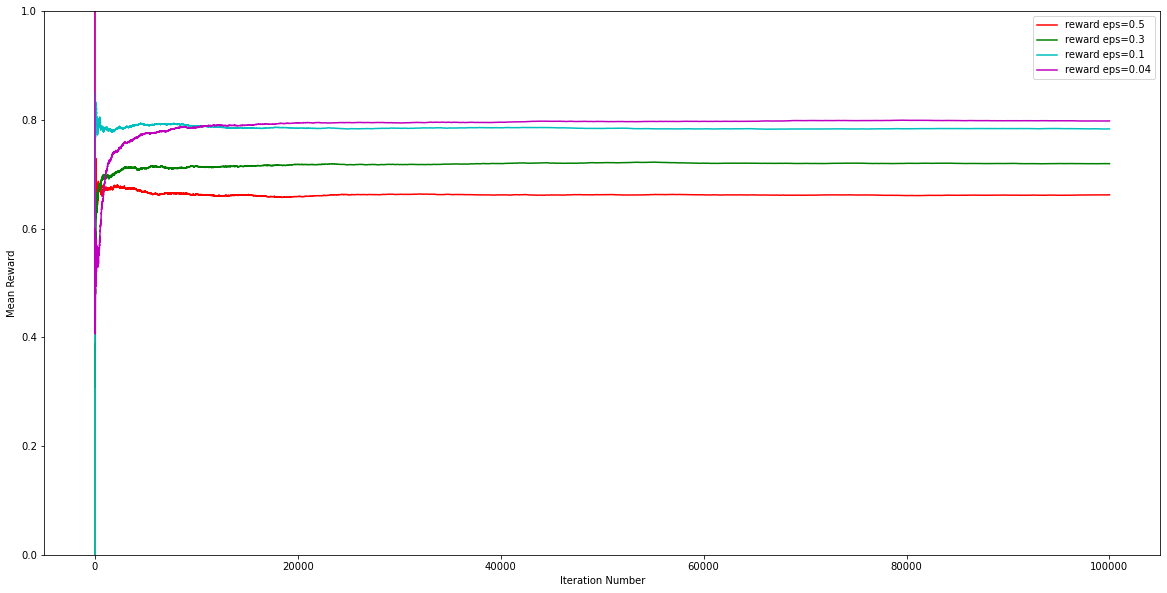

In [82]:
def use_epsilon_greedy(self) -> int:
    if random.random() < self.choose_parameters["epsilon"]:
        bandit_num = random.randint(0, len(self.bandits) - 1)
    else:
        bandit_num = np.random.choice(np.argwhere(self.bandit_means == np.max(self.bandit_means)).squeeze(axis=1))
    return bandit_num


bandit_probs = [0.2, 0.34, 0.56, 0.67, 0.81]
epsilons = [0.5, 0.3, 0.1, 0.04]
colors = ['r', 'g', 'c', 'm', 'k']
legend = []

for i, eps in enumerate(epsilons):
    agent = Agent(bandit_probs)
    agent.set_agent_algorithm(use_epsilon_greedy, epsilon=eps)
    experiment = Experiment(agent)
    experiment.run(100000)
    experiment.plot_mean_rewards(color=colors[i])
    legend.append("reward eps={}".format(eps))
_ = plt.legend(legend)

The lower the epsilon, the better the final result. However, the problem is at the beginning of the iteration, the convergence to the best reward result become slower. We can solve this issue by making epsilon as a function like: $$ \epsilon \propto 1/t $$

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 81328.92it/s]


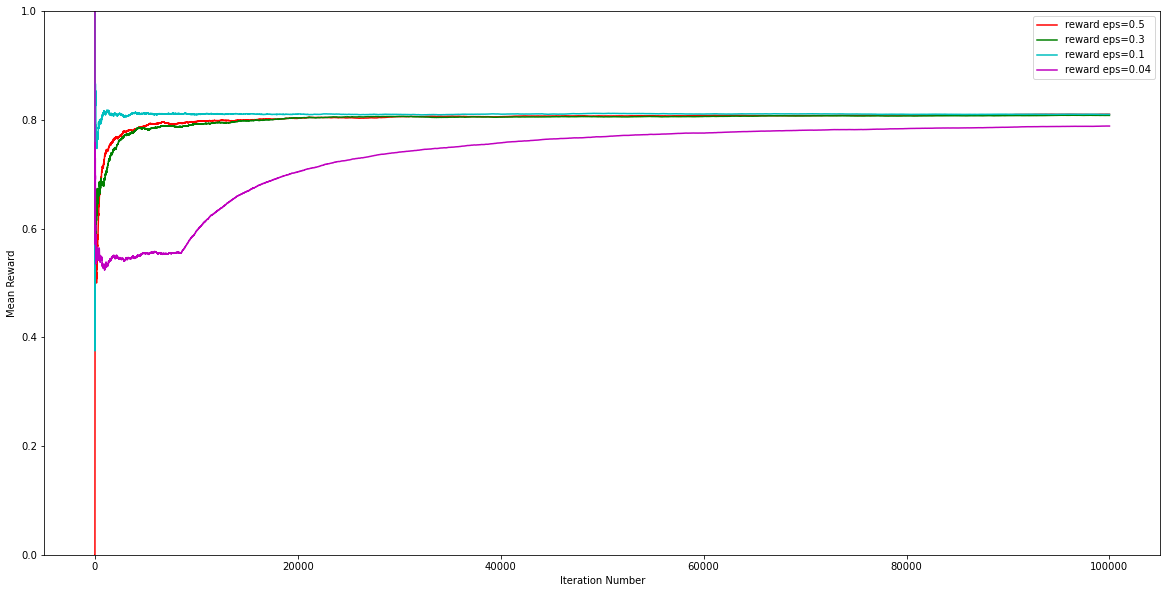

In [81]:
def use_epsilon_greedy(self) -> int:
    self.choose_parameters["iter_num"] += 1
    if random.random() < self.choose_parameters["epsilon"]/math.sqrt(self.choose_parameters["iter_num"]):
        bandit_num = random.randint(0, len(self.bandits) - 1)
    else:
        bandit_num = np.random.choice(np.argwhere(self.bandit_means == np.max(self.bandit_means)).squeeze(axis=1))
    return bandit_num


bandit_probs = [0.2, 0.34, 0.56, 0.67, 0.81]
epsilons = [0.5, 0.3, 0.1, 0.04]
colors = ['r', 'g', 'c', 'm', 'k']
legend = []

for i, eps in enumerate(epsilons):
    agent = Agent(bandit_probs)
    agent.set_agent_algorithm(use_epsilon_greedy, epsilon=eps, iter_num = 0)
    experiment = Experiment(agent)
    experiment.run(100000)
    experiment.plot_mean_rewards(color=colors[i])
    legend.append("reward eps={}".format(eps))
_ = plt.legend(legend)

As you can see, for all epsilon values, the final result is converges to a certain value even for smaller epsilons convergence is very slow. However, the trade off for this situation is that, the current problem is stationary, i.e., the probabilities of bandits don't change. If it is a non-stationary problem, then the decaying epsilon will cause problems since it prevent the agent from exploring new probability changes with very small epsilon values.

### Optimistic Initial Values
